In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import os

In [ ]:
r = np.array([      # five variables: 3 objectives, 2 constraints
    [1.0, 0.4, -0.5, 0.3, -0.2],
    [0.4, 1.0, 0.5, -0.3, -0.4],
    [-0.5, 0.5, 1.0, 0.2, -0.3],
    [0.3, -0.3, 0.2, 1.0, 0.5],
    [-0.2, -0.4, -0.3, 0.5, 1.0]
])

n = 50000
shape, scale = [1.0, 2.0, 5.0, 1.5, 8.0], [2.0, 1.0, 0.5, 1.5, 0.3]

In [3]:
def make_pos_def(corr):
    eigvals, eigvecs = np.linalg.eigh(corr)
    eigvals[eigvals < 1e-8] = 1e-8  
    corr_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # normalize diagonal to 1
    d = np.sqrt(np.diag(corr_pd))
    corr_pd = corr_pd / d[:, None] / d[None, :]
    return corr_pd
r_psd = make_pos_def(r)

In [ ]:
r_psd

In [4]:
mean = np.zeros(np.shape(r_psd)[0])
z = np.random.multivariate_normal(mean, r_psd, size=n)
u = stats.norm.cdf(z)

In [5]:
samples = np.zeros_like(u)
for i in range(u.shape[1]):
    samples[:, i] = stats.gamma.ppf(u[:, i], a=shape[i], scale=scale[i])

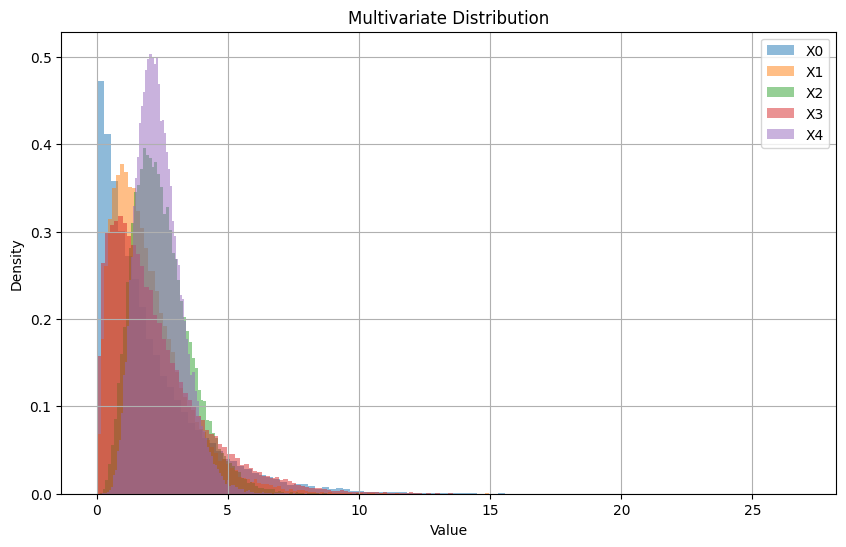

In [6]:
n_dims = samples.shape[1]

plt.figure(figsize=(10, 6))
for i in range(n_dims):
    plt.hist(samples[:, i], bins=100, density=True, alpha=0.5, label=f"X{i}")

plt.title("Multivariate Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
# plt.xlim(0, 6)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
expected_values = [a * b for a, b in zip(shape, scale)]

In [8]:
# generate data
def generate_knapsack_data(samples, shape, scale,         
                           n_items=10, max_trials=1000, exp_n_selected=5, trial_needed=100):

    # create column names (list)
    columns = (
        ['trial_number'] +
        [f'value1_item_{i+1}' for i in range(n_items)] +
        [f'value2_item_{i+1}' for i in range(n_items)] +
        [f'value3_item_{i+1}' for i in range(n_items)] +
        [f'weight1_item_{i+1}' for i in range(n_items)] +
        [f'weight2_item_{i+1}' for i in range(n_items)] +
        ['capacity1', 'capacity2']
    )

    # create df with 0's
    df = pd.DataFrame(0, index=range(max_trials), columns=columns)

    valid_trials = 0
    trial_i = 0
    n_invalid_capacity = 0
    n_invalid_weight_ratio = 0
    while valid_trials < trial_needed and trial_i < max_trials:
        # obtain value and weigh,ts for the trial
        values1 = np.floor(samples[trial_i*n_items: trial_i*n_items+n_items, 0]).astype(int)
        values2 = np.floor(samples[trial_i*n_items: trial_i*n_items+n_items, 1]).astype(int) 
        values3 = np.floor(samples[trial_i*n_items: trial_i*n_items+n_items, 2]).astype(int) 
        weights1 =  -np.floor(samples[trial_i*n_items: trial_i*n_items+n_items, 3]).astype(int) 
        weights2 =  -np.floor(samples[trial_i*n_items: trial_i*n_items+n_items, 4]).astype(int) 
        
        # obtain capacities for the trial
        # expected number of items selected: exp_n_selected
        cp1 = stats.gamma.rvs(a=shape[3], scale=scale[3], size=1)[0] # can sample out of the loop
        cp2 = stats.gamma.rvs(a=shape[4], scale=scale[4], size=1)[0]
        capacity1 = -np.floor(cp1 * exp_n_selected).astype(int) 
        capacity2 = -np.floor(cp2 * exp_n_selected).astype(int) 

        # check if capacity is zero
        if capacity1 == 0 or capacity2 == 0:
            n_invalid_weight_ratio += 1
            trial_i += 1
            continue
        
        # check if largest weight ratio is equal to orbelow 0.4
        ratios = np.vstack([
            weights1 / capacity1,
            weights2 / capacity2,
        ])
        largest_weight_ratio = ratios.max(axis=0) 
        if np.any(largest_weight_ratio > 0.4):
            n_invalid_weight_ratio += 1
            trial_i += 1
            continue
        
        # store data into df
        df.loc[valid_trials, 'trial_number'] = valid_trials + 1
        for i in range(n_items):
            df.loc[valid_trials, f'value1_item_{i+1}'] = values1[i]
            df.loc[valid_trials, f'value2_item_{i+1}'] = values2[i]
            df.loc[valid_trials, f'value3_item_{i+1}'] = values3[i]
            df.loc[valid_trials, f'weight1_item_{i+1}'] = weights1[i]
            df.loc[valid_trials, f'weight2_item_{i+1}'] = weights2[i] 
        df.loc[valid_trials, 'capacity1'] = capacity1
        df.loc[valid_trials, 'capacity2'] = capacity2
    
        valid_trials += 1
        trial_i += 1

    df = df.iloc[:trial_needed].reset_index(drop=True)  

    output_dir = f'/Users/tailai/knapsack_simu/simu_summer/experiment_data'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f'card_game_n{n_items}_n_exp{exp_n_selected}.csv')
    if os.path.exists(output_path):
        print(f"File {output_path} already exists")
    else:
        df.to_csv(output_path, index=False)
        print(f"File {output_path} created successfully")

    print(f"n_invalid_weight_ratio: {n_invalid_weight_ratio}")

In [ ]:
np.corrcoef(samples.T)

In [9]:
generate_knapsack_data(samples, shape, scale,
                       n_items=50, max_trials=1000, exp_n_selected=10, trial_needed=100)

File /Users/tailai/knapsack_simu/simu_summer/experiment_data/card_game_n50_n_exp10.csv created successfully
n_invalid_weight_ratio: 149


In [23]:
n_items = 50
df = pd.read_csv('/Users/tailai/knapsack_simu/simu_summer/experiment_data/card_game_n50_n_exp10.csv')
df.head()

,trial_number,value1_item_1,value1_item_2,value1_item_3,value1_item_4,value1_item_5,value1_item_6,value1_item_7,value1_item_8,value1_item_9,...,weight2_item_43,weight2_item_44,weight2_item_45,weight2_item_46,weight2_item_47,weight2_item_48,weight2_item_49,weight2_item_50,capacity1,capacity2
0,1,1,0,1,2,0,3,0,1,0,...,-3,-3,-2,-3,-2,-1,-1,-2,-31,-22
1,2,1,0,1,0,1,2,0,0,0,...,-3,-4,-1,-3,-1,0,-2,-3,-24,-24
2,3,0,1,0,2,1,2,0,5,8,...,-3,-2,-3,-3,-2,-1,-2,-1,-18,-19
3,4,0,0,0,0,1,0,0,1,1,...,-3,-2,-1,-2,-1,-3,-1,-3,-26,-16
4,5,0,0,5,1,0,0,5,5,2,...,-2,-3,-3,-2,-1,-4,-2,-3,-36,-27


In [24]:
# reshape data for visualization
items_df_visual = pd.DataFrame()

for trial in range(len(df)):
    trial_data = []
    for item in range(1, n_items+1): 
        row = {
            'Card number': item,
            'Science': df[f'value1_item_{item}'][trial],
            'Culture': df[f'value2_item_{item}'][trial],
            'Govern': df[f'value3_item_{item}'][trial],
            'Money': df[f'weight1_item_{item}'][trial],
            'Space': df[f'weight2_item_{item}'][trial],
            # 'capacity1': df['capacity1'][trial],
            # 'capacity2': df['capacity2'][trial],
        }
        trial_data.append(row)
    items_df_visual = pd.concat([items_df_visual, pd.DataFrame(trial_data)], ignore_index=True) ## create a new sequential index

items_df_visual.head(50)

,Card number,Science,Culture,Govern,Money,Space
0,1,1,1,1,-1,-2
1,2,0,1,4,-4,-2
2,3,1,0,1,-4,-1
3,4,2,2,1,-2,-3
4,5,0,4,4,-2,-2
5,6,3,2,1,0,-1
6,7,0,1,2,0,-1
7,8,1,3,3,0,-1
8,9,0,3,3,0,0
9,10,1,1,1,-1,-2


In [ ]:
items_df_visual.iloc[:, 1:].corr(method='pearson')

,Science,Culture,Govern,Money,Space
Science,1.000000,0.281634,-0.343086,-0.218591,0.115377
Culture,0.281634,1.000000,0.405585,0.208902,0.345496
Govern,-0.343086,0.405585,1.000000,-0.102134,0.246314
Money,-0.218591,0.208902,-0.102134,1.000000,0.418940
Space,0.115377,0.345496,0.246314,0.418940,1.000000


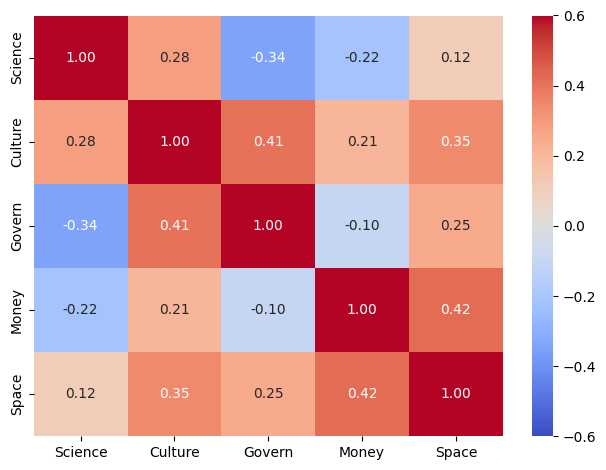

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(items_df_visual.iloc[:, 1:].corr(method='pearson'),
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  
# plt.savefig("corr_matrix_50cards.png", dpi=300, bbox_inches='tight')
plt.show()

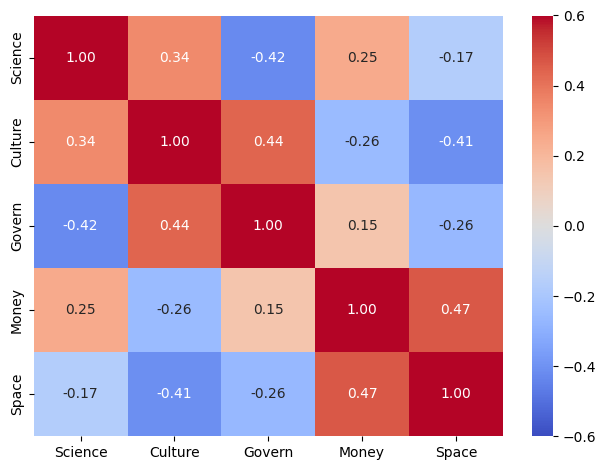

In [40]:
labels = ["Science", "Culture", "Govern", "Money", "Space"]
sns.heatmap(r_psd, xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  # ensures labels aren’t cut off
plt.savefig("corr_matrix_orginal.png", dpi=300, bbox_inches='tight')  # save before show
plt.show()